Obtain analytical distributions

Trying to make GMM plot better

In [1]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

In [2]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [3]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [4]:
# Load model
log_dir = './models'

# for provided, use ts=20
# model_name = 'int_ee_me'

# compute canada full trained
# the training diverges after epoch 7
# model_name = 'models_17_Mar_2021_11_50_44_int_ee_me'

# compute canada full trained
# prediction horizon 8
model_name = 'models_19_Mar_2021_22_14_19_int_ee_me_ph8'

# compute canada partially trained up to epoch 14
# model_name = 'models_18_Mar_2021_22_50_37_int_ee_me'

# compute canada partially trained up to epoch 12
# prediction horizon 8
# model_name = 'models_19_Mar_2021_00_39_24_int_ee_me_ph8'

# compute canada full trained
# model_name = 'models_17_Mar_2021_19_20_17_int_ee'

# compute canada full trained
# must set waypoint for robot?
# model_name = 'models_17_Mar_2021_19_17_00_robot'

# partial training success
# model_name = 'models_02_Mar_2021_22_37_40_int_ee'

model_dir = os.path.join(log_dir, model_name)
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=12)


Loading from ./models/models_19_Mar_2021_22_14_19_int_ee_me_ph8/model_registrar-12.pt
Loaded!



### Combining forecast and map

In [28]:
def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene


# scene = get_scene('555')
# scene = get_scene('523')
def sample_1():
    """Bi-modality at intersection turn left or right"""
    return eval_scenes[25], 10

def sample_2():
    """Two cars moving into the same 1-way lane"""
    return get_scene('907'), 5

scene, t = sample_1()

ph = 8
num_samples = 100
timesteps = np.array([t])

7 Vehicles
Map centered on node VEHICLE/ego


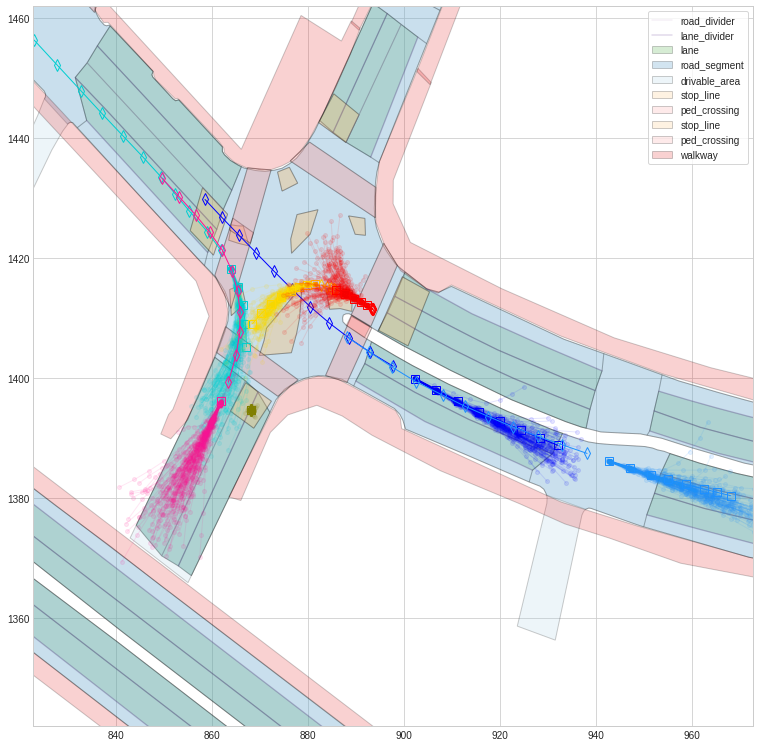

In [29]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
# node = next(filter(lambda k: 'ego' in repr(k), v_nodes))
node = v_nodes[0]

print(f"{len(v_nodes)} Vehicles")
print("Map centered on node", node)

minpos = np.array([scene.x_min, scene.y_min])
ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = np.array([
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty])

center = minpos + ego_lastpos
viewport_hw = 50
my_patch = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)
if scene.map_name != nusc_map.map_name:
    nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=scene.map_name)
fig, ax = nusc_map.render_map_patch(my_patch, scene.layer_names,
        figsize=(10, 10), alpha=0.2, render_egoposes_range=False)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]
    player_future += minpos
    player_past += minpos
    player_predict += minpos

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

### Obtain the analytical PMF of p(z|x)

Obtain the PMF of p(z|x) via tf.distribution.OneHotCategorical.probs

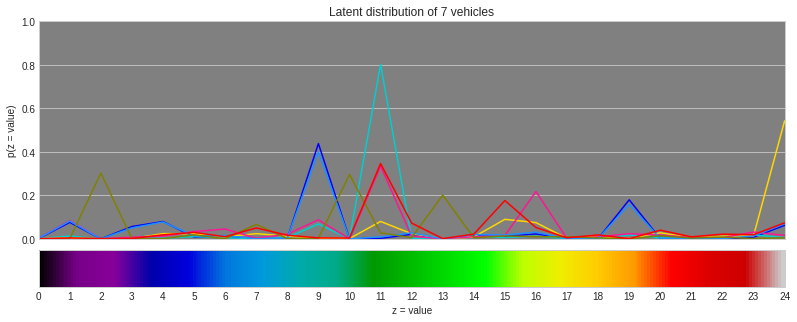

In [30]:
def generate_vehicle_latent_probs(
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)
    
    # model.latent is a DiscreteLatent
    # model.latent.p_dist is a tf.distribution.OneHotCategorical
    model.latent.p_dist = model.p_z_x(mode, x)
    # gets model.latent.p_dist.probs
    probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    return np.squeeze(probs, axis=1), nodes

probs, nodes = generate_vehicle_latent_probs(
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)
n_vehicles = len(nodes)

fig, ax1 = plt.subplots(figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(probs):
    ax1.plot(range(25), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
colorbar = plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

### Obtain the analytical PDF of p(y|x)

Obtain the PDF of p(y|x)

TODO: multivariate GMM computation is numerically unstable / not completely correct
TODO: still has to be optimized

In [31]:
def generate_vehicle_gmms(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    dist, _ = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    
    return dist, nodes

def multivariate_gmm(pos, pis, mus, covs):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    
    TODO: numerically unstable
    """
    gaussians = []
    for idx in range(pis.shape[0]):
        mu = mus[idx]
        Sigma = covs[idx]
        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
        gaussian = np.exp(-fac / 2) / N
        gaussians.append(gaussian)
    gmm = np.zeros(gaussians[0].shape)
    for idx in range(pis.shape[0]):
        gmm += pis[idx]*gaussians[idx]
    gmm = np.nan_to_num(gmm)
    return gmm

In [43]:
dist, nodes = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode = False,
        full_dist = True, all_z_sep = False)

# Parameters of GMM
# eavh (sample, vehicle, timestep) is a GMM 
# has shape (# samples, # vehicles, # timesteps, 25)
log_pis = dist.log_pis.cpu().detach().numpy()
# has shape (# samples, # vehicles, # timesteps, 25, 2)
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
# has shape (# samples, # vehicles, # timesteps, 25, 2, 2)
covs = dist.get_covariance_matrix().cpu().detach().numpy()
log_pis = log_pis[0]
pis = np.exp(log_pis)
mus = mus[0]
sigmas = sigmas[0]
covs = covs[0]

/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: overflow encountered in exp
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/matplotlib/ticker.py:2546: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (np.log(vmax) - np.log(vmin))


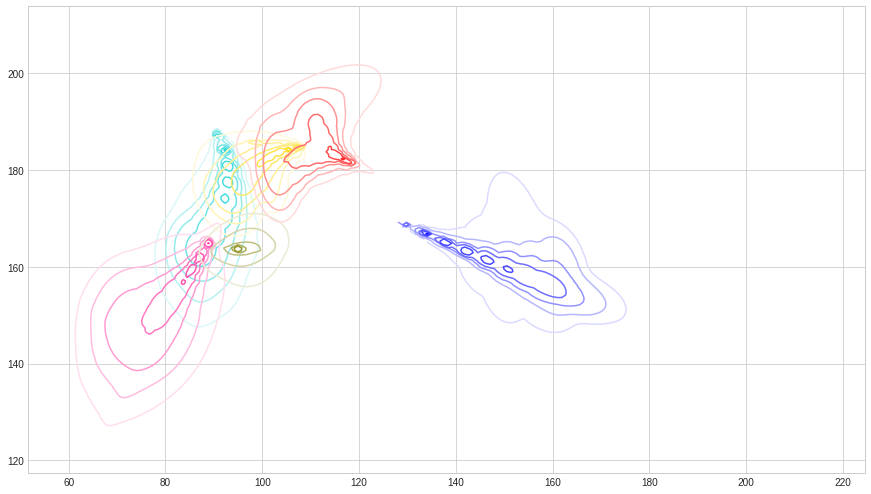

In [44]:
centers = mus.reshape((-1, 2))
cover = 3*sigmas.reshape((-1, 2))
min_extent = np.min(centers - cover, axis=0)
max_extent = np.max(centers + cover, axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 0.000001

N = 200
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')

for v_idx in range(mus.shape[0]):
    v_pis = pis[v_idx]
    v_mus = mus[v_idx]
    v_covs = covs[v_idx]
    Zs = []
    cmap = LinearSegmentedColormap.from_list("",
            ["white", AGENT_COLORS[v_idx % NCOLORS]])
    for p_idx in range(mus.shape[1]):
        p_pis = v_pis[p_idx]
        p_mus = v_mus[p_idx]
        p_covs = v_covs[p_idx]
        Z = multivariate_gmm(pos, p_pis, p_mus, p_covs)
        Zs.append(Z)
    Zs = np.array(Zs)
    Z = np.max(Zs, axis=0)
    # seems like the prob dist is not scaled properly?
    # print(np.max(Z))
    Z = np.ma.masked_where(np.abs(Z) < TOL, Z)
    cs = ax.contour(X, Y, Z, 12,
            cmap=cmap,
            locator=ticker.LogLocator())


In [ ]:
centers = mus.reshape((-1, 2))
cover = 2*sigmas.reshape((-1, 2))
min_extent = np.min(centers - cover, axis=0)
max_extent = np.max(centers + cover, axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6

N = 60
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pos = pos.reshape((-1, 2))
pos = torch.Tensor(pos)
print(pos.shape)

## how to use log_prob???
dist.log_prob(pos)
